In [1]:
from setup import *

# 1. Simulation of sequencing artefacts from DNA templates

## 1.1. simulation function

In [2]:
def simulate_artefacts_with_diff_concordant_ratios (candidate_sites, initial_hits_perc, seq_chance, rand_seed):
    np.random.seed(rand_seed)
    
    ## simulate total deamination events, and the initial chance of being deaminated is the same for both types of cytosines:
    total_hits_num = int(candidate_sites * initial_hits_perc)    ## total deaminated sites among all candidates
    
    hit_sets_s1 = random.sample(range(candidate_sites), total_hits_num)    ## randomly assign the total deaminated events for all candidates in sample 1
    hit_sets_s2 = random.sample(range(candidate_sites), total_hits_num)    ## randomly assign the total deaminated events for all candidates in sample 2

    ## simulate the sequencing process, assuming uracial-containing templates are more likely degraded and also not being favoured during PCR 
    seq_hits_num = int(total_hits_num * seq_chance)    ## total deaminated events would be sequenced
    
    hits_s1_seq = hit_sets_s1[:seq_hits_num]    ## we took the actual-sequenced hits out from sample 1
    hits_s2_seq = hit_sets_s2[:seq_hits_num]    ## we took the actual-sequenced hits out from sample 2

    concordant_hits_s1_s2 = len(np.intersect1d(hits_s1_seq, hits_s2_seq))    ## checking the concordant hits between the sequenced ones. the numerator 

    total_hits_s1_s2 = len(set(list(hits_s1_seq)+list(hits_s2_seq)))    ## checking the total intersection of artefacts observed in s1 and s2. the denonamitor
    
    return (concordant_hits_s1_s2, total_hits_s1_s2, concordant_hits_s1_s2/total_hits_s1_s2)    ## return the abosolute num and concordant ratio back

## 1.2. Channel index

In [3]:
## channel index 
C2T_CpG_ind = []
C2T_nonCpG_ind = []

for c in channels:
    c1,c2 = c.split("@")
    C2T_CpG_ind.append(c1 == "C>T" and c2[1:] == "CG")
    C2T_nonCpG_ind.append(c1 == "C>T" and c2[1:] != "CG")

## unrepaired sig (CpG and nonCpG distribution)

CpG_props_unrepaired = ffpe_sig_unrepaired[C2T_CpG_ind]
norm_CpG_props_unrepaired = CpG_props_unrepaired/sum(CpG_props_unrepaired)

nonCpG_props_unrepaired = ffpe_sig_unrepaired[C2T_nonCpG_ind]
norm_nonCpG_props_unrepaired = nonCpG_props_unrepaired/sum(nonCpG_props_unrepaired)

## repaired sig (CpG and nonCpG distribution)
CpG_props_repaired = ffpe_sig_repaired[C2T_CpG_ind]
norm_CpG_props_repaired = CpG_props_repaired/sum(CpG_props_repaired)

nonCpG_props_repaired = ffpe_sig_repaired[C2T_nonCpG_ind]
norm_nonCpG_props_repaired = nonCpG_props_repaired/sum(nonCpG_props_repaired)

## Normalisation
wgs_opp_df = pd.read_csv("./Data/WGS_opp.csv")
wgs_opp = wgs_opp_df['Probability'].values
def transfer_sig(from_sig, from_opp, to_opp = wgs_opp):
    to_sig = from_sig / from_opp * to_opp
    to_sig = to_sig / np.sum(to_sig)
    return (to_sig)

## 1.3. Simulation setup

We assigned the non-methylated and methylated cytosine sites based on mutational opportunity matrix for the targed region of study 1 (Fig S5a), representing the relative proportions of the true targeted size for both sites.

In [4]:
## opportunity matrix for targed region in Fig S5a.
opportunity_TargetCRC = np.array([0.01157734, 0.01003739, 0.00465863, 0.00887966, 0.01681208,
       0.01212574, 0.00755574, 0.01321701, 0.01286248, 0.01322255,
       0.00537876, 0.01259659, 0.0126963 , 0.01432489, 0.0047528 ,
       0.01292896, 0.01157734, 0.01003739, 0.00465863, 0.00887966,
       0.01681208, 0.01212574, 0.00755574, 0.01321701, 0.01286248,
       0.01322255, 0.00537876, 0.01259659, 0.0126963 , 0.01432489,
       0.0047528 , 0.01292896, 0.01157734, 0.01003739, 0.00465863,
       0.00887966, 0.01681208, 0.01212574, 0.00755574, 0.01321701,
       0.01286248, 0.01322255, 0.00537876, 0.01259659, 0.0126963 ,
       0.01432489, 0.0047528 , 0.01292896, 0.00604348, 0.01021465,
       0.01263537, 0.00855283, 0.00476388, 0.01299543, 0.01762083,
       0.01225315, 0.00599917, 0.00911785, 0.0123861 , 0.00764991,
       0.00491899, 0.01228639, 0.01130591, 0.01096247, 0.00604348,
       0.01021465, 0.01263537, 0.00855283, 0.00476388, 0.01299543,
       0.01762083, 0.01225315, 0.00599917, 0.00911785, 0.0123861 ,
       0.00764991, 0.00491899, 0.01228639, 0.01130591, 0.01096247,
       0.00604348, 0.01021465, 0.01263537, 0.00855283, 0.00476388,
       0.01299543, 0.01762083, 0.01225315, 0.00599917, 0.00911785,
       0.0123861 , 0.00764991, 0.00491899, 0.01228639, 0.01130591,
       0.01096247])

cytosine_sites = 10000     ## Assumed total targeted cytosine sites. We note that changing this number does not change the observations shown below. 

CpG_opp = opportunity_TargetCRC[C2T_CpG_ind].sum()/(opportunity_TargetCRC[C2T_nonCpG_ind].sum() + opportunity_TargetCRC[C2T_CpG_ind].sum())

CpG_sites_num = cytosine_sites * CpG_opp * 0.75  ## 5mC numbers (0.75 is the mean of methylation rate (70-80%))

non_CpG_sites_num = cytosine_sites - CpG_sites_num ## non-5mC numbers

print (f"CpG sites = {int(CpG_sites_num)}, nonCpG sites = {int(non_CpG_sites_num)}")

CpG sites = 965, nonCpG sites = 9034


# 2. Simulate unrepaired samples

## 2.1 With sampling bias

Also, we assumed the inital deamination events are randomly distributed for both targeted sites but at a higher chance as “the actual amplifiable templates are significantly depleted due to the cross-links generated between intracellular macromolecules”. Therefore, those non-amlifiable templates, also containing deaminated cytosines, were not able to be observed in real sequencing data.

We applied the different sequencing chance for CpG and nonCpG sites using 0.9 and 0.35, respectively. There is a possiblity that the second structure of CpG-rich templates has protected their integrity of those DNA template from further damaging or denaturation during fixation.

In [5]:
simulated_unrepaired_biased = pd.DataFrame()

cs_to_repaired_sig_biased = []
cs_to_unrepaired_sig_biased = []

concordant_ratios_nonCpG_biased = []
concordant_ratios_CpG_biased = []
initial_deaminated_perc = 0.45 ## same for CpG_sites and nonCpG sites.

for i in range(100):
    sample_id = 's' + str(i)
    np.random.seed (i)
    concordant_mut_num_nonCpG, total_mut_num_nonCpG, concordant_ratio_nonCpG= simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(non_CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc,
                                                                                seq_chance = np.random.uniform(0.3,0.4), ## non-CpG templates are not favoured
                                                                                rand_seed = i)

    concordant_mut_num_CpG, total_mut_num_CpG, concordant_ratio_CpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc,
                                                                                seq_chance = np.random.uniform(0.85,0.95), ## CpG templates are favoured
                                                                                rand_seed = i)

    mut_profile_of_given_sample =  np.zeros (96)
    mut_profile_of_given_sample [C2T_CpG_ind]= norm_CpG_props_unrepaired * int(total_mut_num_CpG/2)
    mut_profile_of_given_sample [C2T_nonCpG_ind]= norm_nonCpG_props_unrepaired * int(total_mut_num_nonCpG/2)
    simulated_unrepaired_biased[sample_id] = np.random.poisson(mut_profile_of_given_sample)  ## introduce poisson noise
    
    concordant_mut_profile = np.zeros (96)
    concordant_mut_profile[C2T_CpG_ind] = norm_CpG_props_unrepaired * int(concordant_mut_num_CpG/2)
    concordant_mut_profile[C2T_nonCpG_ind] = norm_nonCpG_props_unrepaired * int(concordant_mut_num_nonCpG/2)
    
    cs_to_repaired_sig_biased.append(cosine_similarity(ffpe_sig_repaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    cs_to_unrepaired_sig_biased.append(cosine_similarity(ffpe_sig_unrepaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    
    concordant_ratios_nonCpG_biased.append(concordant_ratio_nonCpG)
    concordant_ratios_CpG_biased.append(concordant_ratio_CpG)

## transfer the mutational probabilities to WGS sequence context:
simulated_unrepaired_biased_transferred = simulated_unrepaired_biased.T.apply(lambda row: transfer_sig(
                                            from_sig = row,
                                            from_opp = np.array (opportunity_TargetCRC), 
                                            to_opp = wgs_opp), axis = 1)
unrepaired_bias_sig = simulated_unrepaired_biased_transferred.mean().values

## 2.2. Without sampling bias

We applied the same sequencing chance of 0.5 for both CpG and nonCpG sites.

In [6]:
simulated_unrepaired_unbiased = pd.DataFrame()

cs_to_repaired_sig_unbiased = []
cs_to_unrepaired_sig_unbiased = []

concordant_ratios_nonCpG_unbiased = []
concordant_ratios_CpG_unbiased = []
for i in range(100):
    sample_id = 's' + str(i)
    np.random.seed (i)
    concordant_mut_num_nonCpG, total_mut_num_nonCpG, concordant_ratio_nonCpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(non_CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                                seq_chance = np.random.uniform(0.45,0.55), ## non-CpG templates are equally favoured
                                                                                rand_seed = i)

    concordant_mut_num_CpG, total_mut_num_CpG, concordant_ratio_CpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                                seq_chance = np.random.uniform(0.45,0.55), ## non-CpG templates are equally favoured                 
                                                                                rand_seed = i)
    
    mut_profile_of_given_sample =  np.zeros (96)
    mut_profile_of_given_sample [C2T_CpG_ind]= norm_CpG_props_unrepaired * int(total_mut_num_CpG/2)
    mut_profile_of_given_sample [C2T_nonCpG_ind]= norm_nonCpG_props_unrepaired * int(total_mut_num_nonCpG/2)
    simulated_unrepaired_unbiased[sample_id] = np.random.poisson(mut_profile_of_given_sample)
    
    concordant_mut_profile = np.zeros (96)
    concordant_mut_profile[C2T_CpG_ind] = norm_CpG_props_unrepaired * int(concordant_mut_num_CpG/2)
    concordant_mut_profile[C2T_nonCpG_ind] = norm_nonCpG_props_unrepaired * int(concordant_mut_num_nonCpG/2)
    
    cs_to_repaired_sig_unbiased.append(cosine_similarity(ffpe_sig_repaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    cs_to_unrepaired_sig_unbiased.append(cosine_similarity(ffpe_sig_unrepaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    
    concordant_ratios_nonCpG_unbiased.append(concordant_ratio_nonCpG)
    concordant_ratios_CpG_unbiased.append(concordant_ratio_CpG)
    
simulated_unrepaired_unbiased_transferred = simulated_unrepaired_unbiased.T.apply(lambda row: transfer_sig(
                                            from_sig = row,
                                            from_opp = np.array (opportunity_TargetCRC), 
                                            to_opp = wgs_opp), axis = 1)
unrepaired_unbias_sig = simulated_unrepaired_unbiased_transferred.mean().values

## 2.3. Visualise the key information

It would be intresting to see the concordant ratio as well as the concordant mutation pattern for both sets of samples.

In [7]:
## Record the key information from the simulated data (unrepaired-biased)
ratio, sim, bias_info, site_info, sig_info = [], [], [], [], []

ratio = concordant_ratios_CpG_biased + concordant_ratios_nonCpG_biased + concordant_ratios_CpG_unbiased + concordant_ratios_nonCpG_unbiased
sim = cs_to_repaired_sig_biased + cs_to_unrepaired_sig_biased + cs_to_repaired_sig_unbiased + cs_to_unrepaired_sig_unbiased 
bias_info = ['With-bias'] * 200 + ['Without-bias'] * 200
site_info = ['CpG'] * 100 + ["nonCpG"] * 100 + ['CpG'] * 100 + ["nonCpG"] * 100
sig_info = ['Repaired-sig'] * 100 + ['Unrepaired-sig'] * 100 + ['Repaired-sig'] * 100 + ['Unrepaired-sig'] * 100

ratio_sim_unrepaired_df = pd.DataFrame()
ratio_sim_unrepaired_df['sim'] = sim
ratio_sim_unrepaired_df['ratio'] = ratio
ratio_sim_unrepaired_df['site_info'] = site_info
ratio_sim_unrepaired_df['bias_info'] = bias_info
ratio_sim_unrepaired_df['sig_info'] = sig_info

ratio_sim_unrepaired_df.groupby(['bias_info', 'site_info','sig_info']).mean()

sim     ratio
bias_info    site_info sig_info                          
With-bias    CpG       Repaired-sig    0.906085  0.251220
             nonCpG    Unrepaired-sig  0.708719  0.084713
Without-bias CpG       Repaired-sig    0.439000  0.124915
             nonCpG    Unrepaired-sig  0.996374  0.125967

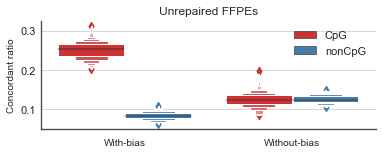

In [8]:
sns.set(rc={"figure.figsize":(6, 2)})
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                     'ytick.major.size': 2,
                                                     'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})
sns.boxenplot(x = 'bias_info', y = 'ratio', data = ratio_sim_unrepaired_df, hue = "site_info", palette= "Set1")
plt.legend (title = "", ncol = 1, frameon = False)
sns.despine()
plt.ylabel ("Concordant ratio", fontsize = 10)
plt.xlabel ("")
plt.title("Unrepaired FFPEs")

plt.xticks(fontsize = 10)
plt.savefig("./Figures/Fig_R3a.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

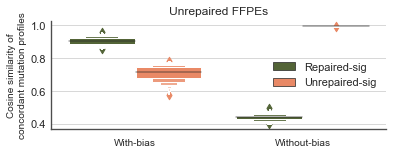

In [9]:
sns.set(rc={"figure.figsize":(6, 2)})
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                     'ytick.major.size': 2,
                                                     'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})
sns.boxenplot(x = 'bias_info', y = 'sim', data = ratio_sim_unrepaired_df, hue = "sig_info", palette= {"Repaired-sig":'darkolivegreen', "Unrepaired-sig": 'coral'})
plt.legend (title = "", loc = "center right", ncol = 1, frameon = False)
sns.despine()
plt.ylabel ("Cosine similarity of\nconcordant mutation profiles", fontsize = 10)
plt.xlabel ("")
plt.xticks(fontsize = 10)
plt.title("Unrepaired FFPEs")

plt.savefig("./Figures/FigR_3b.pdf", bbox_inches = "tight", dpi = 300)

plt.show()

## 2.4. Repaired FFPE

To check if the sampling bias has an impact on signature inference, we also simulated repaired FFPE samples. Here we assign a very low chance (0.75%) to nonCpG templates as there are still a small proportion of deaminated nonCpG sites may escape from the UDG treatment.

## 2.5. To simulate repaired FFPE samples with sampling bias

In [10]:
simulated_repaired_biased = pd.DataFrame()

cs_to_repaired_sig_biased = []
cs_to_unrepaired_sig_biased = []

concordant_ratios_nonCpG_biased = []
concordant_ratios_CpG_biased = []

for i in range(100):
    sample_id = 's' + str(i)
    np.random.seed (i)
    concordant_mut_num_nonCpG, total_mut_num_nonCpG, concordant_ratio_nonCpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(non_CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                                seq_chance = np.random.uniform(0.005,0.01), ## escaped from chemical treatment
                                                                                rand_seed = i)

    concordant_mut_num_CpG, total_mut_num_CpG, concordant_ratio_CpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                               seq_chance = np.random.uniform(0.85,0.95), ## CpG templates are favoured
                                                                                #seq_chance = np.random.uniform(0.45,0.55), ## non-CpG templates are favoured                 
                                                                                rand_seed = i)

    mut_profile_of_given_sample =  np.zeros (96)
    mut_profile_of_given_sample [C2T_CpG_ind]= norm_CpG_props_repaired * int(total_mut_num_CpG/2)
    mut_profile_of_given_sample [C2T_nonCpG_ind]= norm_nonCpG_props_repaired * int(total_mut_num_nonCpG/2)
    simulated_repaired_biased[sample_id] = np.random.poisson(mut_profile_of_given_sample)

    concordant_mut_profile = np.zeros (96)
    concordant_mut_profile[C2T_CpG_ind] = norm_CpG_props_repaired * int(concordant_mut_num_CpG/2)
    concordant_mut_profile[C2T_nonCpG_ind] = norm_nonCpG_props_repaired * int(concordant_mut_num_nonCpG/2)
    
    cs_to_repaired_sig_biased.append(cosine_similarity(ffpe_sig_repaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    cs_to_unrepaired_sig_biased.append(cosine_similarity(ffpe_sig_unrepaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    
    concordant_ratios_nonCpG_biased.append(concordant_ratio_nonCpG)
    concordant_ratios_CpG_biased.append(concordant_ratio_CpG)

simulated_repaired_biased_transferred = simulated_repaired_biased.T.apply(lambda row: transfer_sig(
                                            from_sig = row,
                                            from_opp = np.array (opportunity_TargetCRC), 
                                            to_opp = wgs_opp), axis = 1)
repaired_bias_sig = simulated_repaired_biased_transferred.mean().values

## 2.6. To simulate repaired FFPE samples without sampling biaswithout bias 

In [11]:
simulated_repaired_unbiased = pd.DataFrame()

cs_to_repaired_sig_unbiased = []
cs_to_unrepaired_sig_unbiased = []

concordant_ratios_nonCpG_unbiased = []
concordant_ratios_CpG_unbiased = []

for i in range(100):
    sample_id = 's' + str(i)
    np.random.seed (i)
    concordant_mut_num_nonCpG, total_mut_num_nonCpG, concordant_ratio_nonCpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(non_CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                                seq_chance = np.random.uniform(0.005,0.01), ## escaped from chemical treatment
                                                                                rand_seed = i)

    concordant_mut_num_CpG, total_mut_num_CpG, concordant_ratio_CpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                                seq_chance = np.random.uniform(0.45,0.55), ## non-CpG templates are favoured                 
                                                                                rand_seed = i)

    mut_profile_of_given_sample =  np.zeros (96)
    mut_profile_of_given_sample [C2T_CpG_ind]= norm_CpG_props_repaired * int(total_mut_num_CpG/2)
    mut_profile_of_given_sample [C2T_nonCpG_ind]= norm_nonCpG_props_repaired * int(total_mut_num_nonCpG/2)
    simulated_repaired_unbiased[sample_id] = np.random.poisson(mut_profile_of_given_sample)

    concordant_mut_profile = np.zeros (96)
    concordant_mut_profile[C2T_CpG_ind] = norm_CpG_props_repaired * int(concordant_mut_num_CpG/2)
    concordant_mut_profile[C2T_nonCpG_ind] = norm_nonCpG_props_repaired * int(concordant_mut_num_nonCpG/2)
    
    cs_to_repaired_sig_unbiased.append(cosine_similarity(ffpe_sig_repaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    cs_to_unrepaired_sig_unbiased.append(cosine_similarity(ffpe_sig_unrepaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    
    concordant_ratios_nonCpG_unbiased.append(concordant_ratio_nonCpG)
    concordant_ratios_CpG_unbiased.append(concordant_ratio_CpG)

simulated_repaired_unbiased_transferred = simulated_repaired_unbiased.T.apply(lambda row: transfer_sig(
                                            from_sig = row,
                                            from_opp = np.array (opportunity_TargetCRC), 
                                            to_opp = wgs_opp), axis = 1)
repaired_unbias_sig = simulated_repaired_unbiased_transferred.mean().values

## 2.7 Visualise the key information for biased and unbiased repaired FFPE samples

We did not include the results from this part in our replies as the concordant mutation profile of repaired pairs is more similar to repaired signatures as expected for all cases.

In [12]:
## Record the key information from the simulated data (unrepaired-biased)
ratio, sim, bias_info, site_info, sig_info = [], [], [], [], []

ratio = concordant_ratios_CpG_biased + concordant_ratios_nonCpG_biased + concordant_ratios_CpG_unbiased + concordant_ratios_nonCpG_unbiased
sim = cs_to_repaired_sig_biased + cs_to_unrepaired_sig_biased + cs_to_repaired_sig_unbiased + cs_to_unrepaired_sig_unbiased 
bias_info = ['With-bias'] * 200 + ['Without-bias'] * 200
site_info = ['CpG'] * 100 + ["nonCpG"] * 100 + ['CpG'] * 100 + ["nonCpG"] * 100
sig_info = ['Repaired-sig'] * 100 + ['Unrepaired-sig'] * 100 + ['Repaired-sig'] * 100 + ['Unrepaired-sig'] * 100

ratio_sim_repaired_df = pd.DataFrame()
ratio_sim_repaired_df['sim'] = sim
ratio_sim_repaired_df['ratio'] = ratio
ratio_sim_repaired_df['site_info'] = site_info
ratio_sim_repaired_df['bias_info'] = bias_info
ratio_sim_repaired_df['sig_info'] = sig_info

ratio_sim_repaired_df.head()

ratio_sim_repaired_df.groupby(['bias_info', 'sig_info']).mean()

sim     ratio
bias_info    sig_info                          
With-bias    Repaired-sig    0.951501  0.252888
             Unrepaired-sig  0.091430  0.001570
Without-bias Repaired-sig    0.951561  0.124763
             Unrepaired-sig  0.091630  0.001871

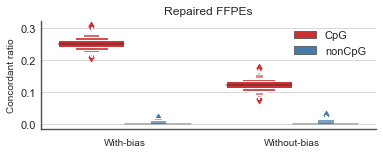

In [13]:
sns.set(rc={"figure.figsize":(6, 2)})
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                     'ytick.major.size': 2,
                                                     'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})
sns.boxenplot(x = 'bias_info', y = 'ratio', data = ratio_sim_repaired_df, hue = "site_info", palette= "Set1")
plt.legend (title = "", ncol = 1, frameon = False)
plt.title("Repaired FFPEs")
sns.despine()
plt.ylabel ("Concordant ratio", fontsize = 10)
plt.xlabel ("")

plt.xticks(fontsize = 10)
plt.show()

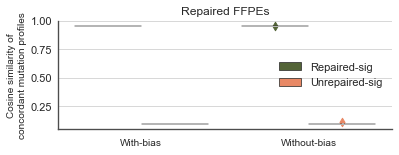

In [14]:
sns.set(rc={"figure.figsize":(6, 2)})
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                     'ytick.major.size': 2,
                                                     'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})
sns.boxenplot(x = 'bias_info', y = 'sim', data = ratio_sim_repaired_df, hue = "sig_info", palette= {"Repaired-sig":'darkolivegreen', "Unrepaired-sig": 'coral'})
plt.legend (title = "", loc = "center right", ncol = 1, frameon = False)
sns.despine()
plt.title ("Repaired FFPEs")
plt.ylabel ("Cosine similarity of\nconcordant mutation profiles", fontsize = 10)
plt.xlabel ("")
plt.xticks(fontsize = 10)
plt.show()

# 3. Compare the derived signatures from biased and unbiased samples in the above simulation

We can finnally compare the derived FFPE noise patterns from different sets of samples. We took the mean values of the FFPE samples as the final signature.

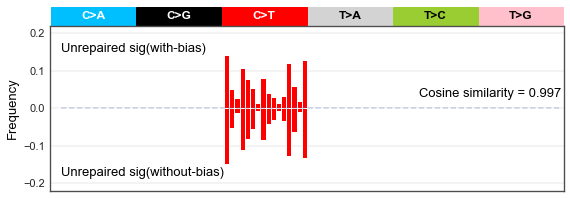

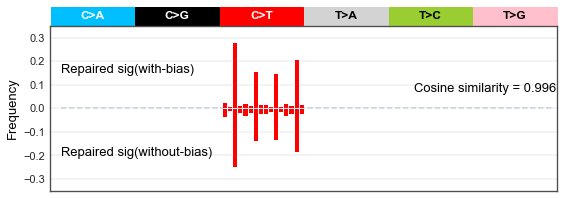

In [15]:
col_set = ['deepskyblue','black','red','lightgrey','yellowgreen','pink']
col_list = []
for i in range (len(col_set)):
     col_list += [col_set[i]] * 16
channel6 = ['C>A','C>G','C>T','T>A','T>C','T>G']

cs_repaired = np.round(cosine_similarity(repaired_unbias_sig.reshape(1,96), repaired_bias_sig.reshape(1,96))[0],3)
cs_unrepaired = np.round(cosine_similarity(unrepaired_unbias_sig.reshape(1,96), unrepaired_bias_sig.reshape(1,96))[0],3)

for sig1, sig2, sig1_name,sig2_name, cs in zip([unrepaired_bias_sig.copy(),repaired_bias_sig.copy()],
                                               [unrepaired_unbias_sig.copy(),repaired_unbias_sig.copy()],
                                               ["Unrepaired sig(with-bias)","Repaired sig(with-bias)"],
                                               [ "Unrepaired sig(without-bias)", "Repaired sig(without-bias)"], 
                                               [cs_unrepaired[0], cs_repaired[0]]):

    sns.set(rc={"figure.figsize":(8, 2.9)})
    sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                     'ytick.major.size': 2,
                                                     'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})

    plt.bar(np.arange(1,97), sig1, color = col_list, width = 1)
    
    plt.bar(np.arange(1,97), -sig2, color = col_list, width = 1)
        
    plt.hlines (0, 1, 97, linestyle='dashed', alpha = 0.3)
    
    for i in range (33,50):
        if sig1[i-1] >0.05  or sig2[i-1] > 0.05:
            if sig1[i-1]/sig2[i-1] > 2 or sig2[i-1]/sig1[i-1] > 2:
                plt.text( i, sig1[i-1] + 0.01, "*", ha = 'center',va='center', size = 12)

    plt.margins(x=0.01, y=0.01)
    plt.xticks ([])
    plt.ylabel("Frequency", color = "black", size = 13)
    
    text_col = ["w","w","w","black","black","black"]
    for i in range(6):
        
        left, width = 0 + 1/6 * i + 0.001, 1/6 - 0.002
        
        bottom, height = 1.003, 0.11
        right = left + width
        top = bottom + height
        ax = plt.gca()
        p = plt.Rectangle((left, bottom), width, height, fill=True, color = col_set[i])
        p.set_transform(ax.transAxes)
        p.set_clip_on(False)
        ax.add_patch(p)
        
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), channel6[i], weight = "bold", 
                color = text_col[i], size = 12,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
        
    plt.tight_layout()
    
    if sig1_name == "Unrepaired sig(with-bias)":
        plt.ylim (-0.22,0.22)
        plt.annotate (sig2_name,(1, -0.18), size = 13 , color = "black")
        plt.annotate (sig1_name,(1, 0.15), size = 13 , color = "black")
        plt.annotate (f"Cosine similarity = {cs}",(70, 0.03), 
                      size = 13, color = "black")
        plt.savefig("./Figures/FigR3c.pdf", bbox_inches = "tight", dpi = 300)
    else:
        plt.ylim (-0.35,0.35)
        plt.annotate (sig2_name,(1, -0.2), size = 13 , color = "black")
        plt.annotate (sig1_name,(1, 0.15), size = 13 , color = "black")
        plt.annotate (f"Cosine similarity = {cs}",(70, 0.07), 
                      size = 13, color = "black")
        plt.savefig("./Figures/FigR3d.pdf", bbox_inches = "tight", dpi = 300)
    
    plt.show()